# COCO format Example
```json
{
    "images": [
        {
            "file_name": "4_21725.jpg",
            "height": 480,
            "width": 854,
            "id": 4021725,
            "is_det_keyframe": false,
            "video_id": 4,
            "frame_id": null,
            "order_in_video": 0,
            "path": "/bd_byta6000i0/users/dataset/MedicalImage/Endoscapes2023/raw/train_seg/4_21725.jpg"
        },
        {
            "file_name": "4_21750.jpg",
            "height": 480,
            "width": 854,
            "id": 4021750,
            "is_det_keyframe": false,
            "video_id": 4,
            "frame_id": null,
            "order_in_video": 1,
            "path": "/bd_byta6000i0/users/dataset/MedicalImage/Endoscapes2023/raw/train_seg/4_21750.jpg"
        },
        ...
    ],
    "annotations": [
        {
            "segmentation": {
                "size": [
                    480,
                    854
                ],
                "counts": ...
            },
            "iscrowd": 0,
            "category_id": 3,
            "bbox": [
                543.0,
                230.0,
                45.0,
                44.0
            ],
            "area": 1329,
            "id": 40224500,
            "image_id": 4022450
        },
        {
            "segmentation": {
                "size": [
                    480,
                    854
                ],
                "counts": ...
            },
            "iscrowd": 0,
            "category_id": 5,
            "bbox": [
                174.0,
                0.0,
                469.0,
                326.0
            ],
            "area": 85739,
            "id": 40224501,
            "image_id": 4022450
        },
        ...
    ],
    "categories": [
        {
            "id": 1,
            "name": "cystic_plate",
            "supercategory": "anatomy"
        },
        {
            "id": 2,
            "name": "calot_triangle",
            "supercategory": "anatomy"
        },
        {
            "id": 3,
            "name": "cystic_artery",
            "supercategory": "anatomy"
        },
        {
            "id": 4,
            "name": "cystic_duct",
            "supercategory": "anatomy"
        },
        {
            "id": 5,
            "name": "gallbladder",
            "supercategory": "anatomy"
        },
        {
            "id": 6,
            "name": "tool",
            "supercategory": "tool"
        }
    ]
}
```

each image has a unique id, and each annotation has a unique id

# Convert Pixel Masks to COCO Format

In [27]:
import numpy as np
from PIL import Image
import pycocotools.mask as mask_util
import json
import cv2
from glob import glob
import os
from natsort import natsorted
from tqdm import tqdm

In [28]:
def get_dicts_by_field_value(data, field_name, target_value):
    return [item for item in data if item.get(field_name) == target_value]


def sort_dicts_by_field(data, field_name, reverse=False):
    return natsorted(data, key=lambda item: item.get(field_name), reverse=reverse)

In [29]:
def create_coco_categories(class_dict):
    categories = []
    for class_id, class_name in class_dict.items():
        category = {
            "id": int(class_id) + 1,
            "name": class_name,
            "supercategory": "",  # 如果需要supercategory，可以在这里添加
        }
        categories.append(category)
    return categories

In [30]:
ann_count = 0

use this `ann_count` to generate `id` for each annotation

In [31]:
def rgb_to_coco(image_path, image_id, color_to_category_id):
    # 打开RGB图像
    img = Image.open(image_path)
    img_array = np.array(img)

    # 初始化COCO格式的annotation列表
    annotations = []

    # 遍历每个颜色到类别ID的映射
    for color, category_id in color_to_category_id.items():
        # 获取当前颜色的掩码
        color_mask = np.all(
            img_array == np.array(color).reshape(1, 1, 3), axis=2
        ).astype(np.uint8)

        # 如果当前颜色在图像中不存在，跳过
        if np.sum(color_mask) == 0:
            continue

        # 将掩码转换为RLE格式
        rle = mask_util.encode(np.asfortranarray(color_mask))
        # 计算面积
        area = mask_util.area(rle)

        # 获取边界框
        bbox = mask_util.toBbox(rle).tolist()

        # 创建annotation字典
        annotation = {
            "id": ann_count,  # 假设annotation ID从1开始递增
            "image_id": image_id,
            "category_id": category_id.item(),
            "segmentation": {
                "size": rle["size"],
                "counts": rle["counts"].decode("utf-8"),
            },
            "area": area.item(),
            "bbox": bbox,
            "iscrowd": 0,
        }

        # 添加到annotations列表
        annotations.append(annotation)
        ann_count += 1

    return annotations

In [32]:
def gray_to_coco(image_path, image_id, category_ids):
    global ann_count
    # 打开灰度图像
    img = Image.open(image_path).convert("L")
    img_array = np.array(img)
    unique = np.unique(img_array)

    # 初始化COCO格式的annotation列表
    annotations = []

    for category_id in category_ids:
        # print(np.unique(img_array))

        # 获取当前类别的掩码
        mask = (img_array == category_id).astype(np.uint8)

        # 如果当前类别在图像中不存在，跳过
        if np.sum(mask) == 0:
            continue

        # 将掩码转换为RLE格式
        rle = mask_util.encode(np.asfortranarray(mask))

        # 计算面积
        area = mask_util.area(rle)

        # 获取边界框
        bbox = mask_util.toBbox(rle).tolist()

        # 创建annotation字典
        annotation = {
            "id": ann_count,  # 假设annotation ID从1开始递增
            "image_id": image_id,
            "category_id": category_id.item(),
            "segmentation": {
                "size": rle["size"],
                "counts": rle["counts"].decode("utf-8"),
            },
            "area": area.item(),
            "bbox": bbox,
            "iscrowd": 0,
        }

        # 添加到annotations列表
        annotations.append(annotation)
        ann_count += 1

    return annotations

## Get Images Info

In [33]:
images = []

In [34]:
img_list = glob(
    "/bd_byta6000i0/users/dataset/MedicalImage/CholecSeg8k/processed_scene/images/test/*png"
)

In [35]:
gt_list = glob(
    "/bd_byta6000i0/users/dataset/MedicalImage/CholecSeg8k/processed_scene/labels/test/*.png"
)

In [36]:
gt_list[0]

'/bd_byta6000i0/users/dataset/MedicalImage/CholecSeg8k/processed_scene/labels/test/video52_00480frame_530_endo_color_mask.png'

## Get Video Ids

In [37]:
example_img_path = img_list[0]
file_name = os.path.basename(example_img_path)
video_id = file_name.split("f")[0]
video_id, file_name

('video48_00801', 'video48_00801frame_804_endo.png')

notice that the video_id is a string, not an integer. and it is not required in the standard COCO format, but it is needed for the inference process.

you can use any str to represent the video_id, as long as you can use it to identify the video in your dataset.

In [38]:
video_id_set = set()

In [39]:
for idx, img_path in enumerate(img_list):
    file_name = os.path.basename(img_path)
    video_id = file_name.split("f")[0]
    video_id_set.add(video_id)
    images.append(
        {
            "file_name": file_name,
            "video_id": video_id,
            "id": idx,
            "path": img_path,
        }
    )
video_id_set

{'video01_00080',
 'video01_00240',
 'video01_16425',
 'video09_00832',
 'video12_19500',
 'video12_19740',
 'video17_01563',
 'video24_00240',
 'video24_00480',
 'video25_00482',
 'video26_01855',
 'video27_00160',
 'video28_00160',
 'video35_01100',
 'video37_00848',
 'video43_00387',
 'video43_00787',
 'video48_00801',
 'video52_00160',
 'video52_00480',
 'video55_00508'}

there is no specific requirements on the id of each frame as long as the id is unique for each frame. the id is used to identify the frame in whole dataset.

## Get the Height and Width of the Image

In [40]:
coco_images = []
coco_annotations = []

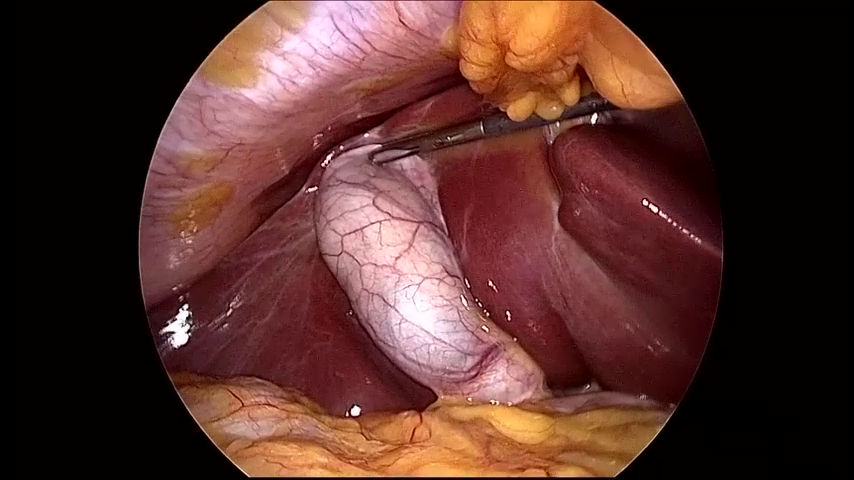

In [41]:
frame_sample = Image.open(img_list[0])
frame_sample

In [42]:
width, height = frame_sample.size
width, height

(854, 480)

notice that we only get the height and width of one image. We suppose that the height and width of all images are the same. if this is not the case, you need to slightly modify the following code.

## Process On Each Video

create empty lists to store the annotations and images

In [43]:
cat_ids = np.arange(1, 13)
cat_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

The `cat_ids` above are for grayscale ground truth images, for color images we will dict like this:

In [44]:
color_map = {
    (255, 0, 0): 1,
    (0, 255, 0): 2,
    (0, 0, 255): 3,
}

and you shoud use `rbg_to_coco` function to convert your rgb image to coco format.

In [45]:
for video_id in tqdm(video_id_set):
    frames = get_dicts_by_field_value(
        images, "video_id", video_id
    )  # get all frames of the same video
    frames = sort_dicts_by_field(frames, "file_name")  # sort the frame in natural order

    for idx, frame in enumerate(frames):
        # find the corresponding ground truth if any
        is_det_keyframe = False
        gt_path = frame["path"]
        gt_path = gt_path.replace("images", "labels")
        gt_path = gt_path.replace("endo.png", "endo_color_mask.png")

        if os.path.exists(gt_path):
            # add the annotation to the coco annotation list
            is_det_keyframe = True
            coco_annotations.extend(gray_to_coco(gt_path, frame["id"], cat_ids))

        # get the height and width of the frame

        # add the frame to the coco frame list
        coco_images.append(
            {
                "file_name": frame["file_name"],
                "path": frame["path"],
                "height": height,
                "width": width,
                "id": frame["id"],
                "video_id": video_id,
                "is_det_keyframe": is_det_keyframe,
                "order_in_video": idx,
            }
        )

100%|██████████| 21/21 [00:23<00:00,  1.14s/it]


In [46]:
coco_annotations[0]

{'id': 0,
 'image_id': 1511,
 'category_id': 1,
 'segmentation': {'size': [480, 854],
  'counts': 'YPh1a08HKHV=m1E`0@9Ac0A:E8K8G<F5I8J;D6K5K8G8I6J5K6K6H6L5J5L1O2N2M3M3N2N2N2N2N2N2N2N2N2N1O2N2N2N2O1N2N101N2O1N2N2O1N2O1N2O1O1N2O0O2O1O1O0O2O1N21O1O1O001O0N3N1O2N2N2M3N1O2L4N2N2N2N1O2M3N1O2N2O0O2M3N1O2O1N2N1O2N2M3L4N101N2L4N1O2N2N1O2N2N2K5N101O1O0OSM`I]M^6d2cI\\M[6e2gIYMW6i2jIWMT6j2mIVMP6l2QJTMn5l2SJSMl5n2UJRMg5Q3YJPMe5Q3]JnL`5T3aJlL^5T3cJlL[5U3eJkLZ5V3gJjLW5W3jJiLT5X3mJhLP5Z3QKgLl4Z3TKfLk4[3VKeLh4\\3YKcLf4^3[KbLa4a3`K_L^4b3cK^L[4c3fK]LX4d3iK[LV4f3kKZLS4g3nKXLQ4i3PLWLo3i3RLWLl3j3ULULj3l3WLSLg3o3ZLQLd3P4]LPL`3R4`LoK^3R4cLnK[3S4fLmKX3T4hLmKV3T4kLkKS3W4nLhKQ3Y4PMgKn2Z4SMeKl2\\4UMdKf2`4[M`Kb2b4_M]K`2d4aM\\K]2e4dM[KZ2f4gMZKW2g4jMXKU2i4lMWKR2j4oMVKn1l4SNTKj1n4WNRKg1o4YNQKe1Q5\\NoJb1R5_NnJ_1S5bNmJ\\1T5eNkJZ1V5gNiJX1X5iNhJU1Y5lNgJR1Z5oNfJn0\\5SOcJl0^5UObJi0_5XObJd0`5]ObJ?_5BaJ;a5E`J:`5G`J7a5J_J4b5M^J2b50\\J0d51[JNf53ZJJh57WJIi57WJHj59UJEm5<RJCo5>PJAQ6`0oI^OR6c0nI[OS6f0mIXOT6i0lIVOT6k0kITOV6m0jIQOW6

In [47]:
coco_images[0:3]

[{'file_name': 'video25_00482frame_482_endo.png',
  'path': '/bd_byta6000i0/users/dataset/MedicalImage/CholecSeg8k/processed_scene/images/test/video25_00482frame_482_endo.png',
  'height': 480,
  'width': 854,
  'id': 1511,
  'video_id': 'video25_00482',
  'is_det_keyframe': True,
  'order_in_video': 0},
 {'file_name': 'video25_00482frame_483_endo.png',
  'path': '/bd_byta6000i0/users/dataset/MedicalImage/CholecSeg8k/processed_scene/images/test/video25_00482frame_483_endo.png',
  'height': 480,
  'width': 854,
  'id': 799,
  'video_id': 'video25_00482',
  'is_det_keyframe': True,
  'order_in_video': 1},
 {'file_name': 'video25_00482frame_484_endo.png',
  'path': '/bd_byta6000i0/users/dataset/MedicalImage/CholecSeg8k/processed_scene/images/test/video25_00482frame_484_endo.png',
  'height': 480,
  'width': 854,
  'id': 531,
  'video_id': 'video25_00482',
  'is_det_keyframe': True,
  'order_in_video': 2}]

## Generate COCO format categories

you can directly write the coco format categories

In [48]:
coco_categories = [
    {"id": 0, "name": "Black Background"},
    {"id": 1, "name": "Abdominal Wall"},
    {"id": 2, "name": "Liver"},
    {"id": 3, "name": "Gastrointestinal Tract"},
    {"id": 4, "name": "Fat"},
    {"id": 5, "name": "Grasper"},
    {"id": 6, "name": "Connective Tissue"},
    {"id": 7, "name": "Blood"},
    {"id": 8, "name": "Cystic Duct"},
    {"id": 9, "name": "L-hook Electrocautery"},
    {"id": 10, "name": "Gallbladder"},
    {"id": 11, "name": "Hepatic Vein"},
    {"id": 12, "name": "Liver Ligament"},
]

or you can use the following method

In [49]:
class_dict = {
    0: "Black Background",
    1: "Abdominal Wall",
    2: "Liver",
    3: "Gastrointestinal Tract",
    4: "Fat",
    5: "Grasper",
    6: "Connective Tissue",
    7: "Blood",
    8: "Cystic Duct",
    9: "L-hook Electrocautery",
    10: "Gallbladder",
    11: "Hepatic Vein",
    12: "Liver Ligament",
}

In [50]:
coco_categories = create_coco_categories(class_dict)
coco_categories

[{'id': 1, 'name': 'Black Background', 'supercategory': ''},
 {'id': 2, 'name': 'Abdominal Wall', 'supercategory': ''},
 {'id': 3, 'name': 'Liver', 'supercategory': ''},
 {'id': 4, 'name': 'Gastrointestinal Tract', 'supercategory': ''},
 {'id': 5, 'name': 'Fat', 'supercategory': ''},
 {'id': 6, 'name': 'Grasper', 'supercategory': ''},
 {'id': 7, 'name': 'Connective Tissue', 'supercategory': ''},
 {'id': 8, 'name': 'Blood', 'supercategory': ''},
 {'id': 9, 'name': 'Cystic Duct', 'supercategory': ''},
 {'id': 10, 'name': 'L-hook Electrocautery', 'supercategory': ''},
 {'id': 11, 'name': 'Gallbladder', 'supercategory': ''},
 {'id': 12, 'name': 'Hepatic Vein', 'supercategory': ''},
 {'id': 13, 'name': 'Liver Ligament', 'supercategory': ''}]

## Completed

In [51]:
coco_info = {
    "images": coco_images,
    "annotations": coco_annotations,
    "categories": coco_categories,
}

In [52]:
with open("coco_annotations.json", "w") as f:
    json.dump(coco_info, f, indent=4)